# **1: Network Testing**

This tutorial demonstrates how to test the double LSTM-based model for the sequence-to-scalar future hysteresis step prediction. The testset seqeunces include data that has the same sampling time steps as the training dataset. The testing data is a single frequency 200kHz data sequence at 25C. Sequence length = 8015 data points


# **Step 0: Import Packages**

In this step we import the important packages that are necessary for the testing.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import json
import math
import csv
import time
import h5py
import matplotlib.pyplot as plt


Mounted at /content/drive


# **Step 1: Define Network Structure**
The structure of the duel LSTM-based encoder-projector-decoder neural network are defined here. The network structure does not change from the training structure. Refer to the PyTorch document for more details.

In [3]:
# Define model structures and functions

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.lstm_B = nn.LSTM(1, 12, num_layers=1, batch_first=True, bidirectional=False)

        self.lstm_H = nn.LSTM(1, 12, num_layers=1, batch_first=True, bidirectional=False)

        self.projector = nn.Sequential(
            nn.Linear(12 *2 + 2 , 12 *2 + 2),
            nn.ReLU(),
            nn.Linear(12 *2 + 2, 8),
            nn.ReLU(),
            nn.Linear(8 , 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, seq_B: Tensor, seq_H: Tensor, scal: Tensor, T: Tensor, device) -> Tensor:

        seq_B = seq_B.float()
        seq_H = seq_H.float()
        scal = scal.float()
        T = T.float()

        x_B, _ = self.lstm_B(seq_B)
        x_B = x_B[:, -1, :]

        x_H, _ = self.lstm_H(seq_H)
        x_H = x_H[:, -1, :]


        output = self.projector(torch.cat((scal, T, x_B, x_H), dim=1))
        output = output.to(device)

        return output

# **Step 2: Load the Testing Dataset**

Dataset needs to be processed before testing. We load the dataset provided by the user, in this case a single seqeunce with a predefined sequences memory length matching the training memory sequence. Output H sequence is post processed again to provide autoregressive function.

In [4]:
#Defind parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load the dataset

def get_dataset(data_length):
    # Load .json Files
    with h5py.File('/content/drive/MyDrive/Colab Notebooks/Minjie Chen/MagNetX/3C90_Testing.h5', 'r') as file:
        print("keys:", list(file.keys()))

        B_list = []
        H_list = []
        B_scal_list = []
        H_out_list = []
        T_scal_list = []

        for i in range(4,5):  # i from 1 to 8
            B_list.append(file[f'B_seq_f_{i}'][:])
            H_list.append(file[f'H_seq_f_{i}'][:])
            B_scal_list.append(file[f'B_scal_{i}'][:])
            H_out_list.append(file[f'H_scal_{i}'][:])
            T_scal_list.append(file[f'T_{i}'][:])
            #print(np.size(B_list))

        # Now concatenate them after the loop
        B = np.concatenate(B_list, axis=0)
        H = np.concatenate(H_list, axis=0)
        B_scal = np.concatenate(B_scal_list, axis=0)
        H_out = np.concatenate(H_out_list, axis=0)
        T_scal = np.concatenate(T_scal_list, axis=0)

    print("Data Loading Initiated")


    # Load from JSON
    with open('/content/drive/MyDrive/Colab Notebooks/Minjie Chen/MagNetX/Normalization_Params.json', 'r') as f:
        Param = json.load(f)

    print("Normalization Initiated")

    mean_B = np.array(Param['mean_B'])
    std_B = np.array(Param['std_B'])
    mean_H = np.array(Param['mean_H'])
    std_H = np.array(Param['std_H'])
    mean_out = np.array(Param['mean_out'])
    std_out = np.array(Param['std_out'])
    mean_Scal = np.array(Param['mean_Scal'])
    std_Scal = np.array(Param['std_Scal'])
    mean_T = np.array(Param['mean_T'])
    std_T = np.array(Param['std_T'])

    B = np.array(B)
    H = np.array(H)
    B_scal = np.array(B_scal)
    H_out = np.array(H_out)
    T_scal = np.array(T_scal)

    B_scal = B_scal.reshape(-1, 1)
    T_scal = T_scal.reshape(-1, 1)
    in_B = B.reshape(-1,data_length, 1)
    in_H = H.reshape(-1,data_length, 1)
    out = H_out.reshape(-1,1)

    B_plot = B_scal  # For plotting later

    normH = [mean_out,std_out ]



    T_scal = (T_scal-mean_T)/std_T
    B_scal = (B_scal-mean_Scal)/std_Scal
    in_B = (in_B-mean_B)/std_B
    in_H = (in_H-mean_H)/std_H
    H_out = (H_out-mean_out)/std_out

    in_H[Nseq : , :] = 0     # Replacing everything after N rows with 0, only retain the first H memory

    B_scal = torch.from_numpy(B_scal)
    T_scal = torch.from_numpy(T_scal)
    in_B = torch.from_numpy(in_B).float().view(-1,data_length, 1)
    in_H = torch.from_numpy(in_H).float().view(-1,data_length, 1)
    out = torch.from_numpy(H_out).float().view(-1,1)


    in_B = in_B.to(dtype=torch.float)
    in_H = in_H.to(dtype=torch.float)
    B_scal = B_scal.to(dtype=torch.float)
    T_scal = T_scal.to(dtype=torch.float)
    out = out.to(dtype=torch.float)

    print(f"in_B is {in_B.size()}")
    print(f"in_H is {in_H.size()}")
    print(f"B_scal is {B_scal.size()}")
    print(f"out is {out.size()}")

    return torch.utils.data.TensorDataset(in_B, in_H , B_scal, T_scal, out), normH, B_plot

# **Step 3: Testing the Model**

The loaded dataset is directly used as the test set. The model state dictionary file (.sd) containing all the trained parameter values is loaded and tested.

keys: ['B_scal_4', 'B_seq_f_4', 'H_scal_4', 'H_seq_f_4', 'T_4']
Data Loading Initiated
Normalization Initiated
in_B is torch.Size([8015, 80, 1])
in_H is torch.Size([8015, 80, 1])
B_scal is torch.Size([8015, 1])
out is torch.Size([8015, 1])
Number of parameters:  2399


<ipython-input-6-f9be54f885c7>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/Minjie Chen/MagNetX/Model_LS

Model is loaded!


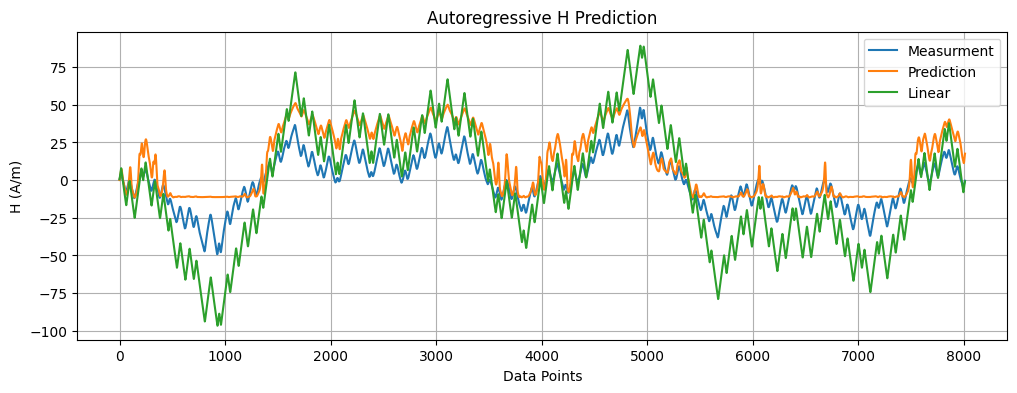

In [6]:
# Config the model Testing
#Defind parameters
step_size = 1
data_length = 80
Nseq = 1  # Number of seqeunces to test. This is also denoted as N no. of seqeunces.

def main():

    # Reproducibility
    random.seed(1)
    np.random.seed(1)
    torch.manual_seed(1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Hyperparameters
    BATCH_SIZE = Nseq # Set the batch size to Nseq becuase we want to retain only the first H memory segment of Nseq number of sequences

    # Select GPU as default device
    device = torch.device("cuda")

    # Load dataset
    dataset, normH, B_plot = get_dataset(data_length)

    # Split the dataset
    kwargs = {'num_workers': 0, 'pin_memory': True, 'pin_memory_device': "cuda"}
    test_loader =  torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
    testData = list(test_loader)

    # Setup network
    net = Net().to(device)

    # Log the number of parameters
    print("Number of parameters: ", count_parameters(net))

    # Load trained parameters
    state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/Minjie Chen/MagNetX/Model_LSTM_New.sd')
    net.load_state_dict(state_dict, strict=True)
    net.eval()
    print("Model is loaded!")

    #Test
    net.eval()
    out_pred = [];
    out_pred = torch.tensor(out_pred)
    out_meas = [];
    out_meas = torch.tensor(out_meas)
    outputs = torch.empty((0,1))
    outputs = outputs.to(device)


    previous_in_H= None
    with torch.no_grad():
        for in_B, in_H, B_scal, T_scal, out in testData:  # Batch level
            # The starting of the first iteration where the first point is predicted using all the H measurement data
            if  previous_in_H is None:
                outputs = net(seq_B = in_B.to(device), seq_H = in_H.to(device), scal = B_scal.to(device), T = T_scal.to(device), device = device)
                out_pred = out_pred.to(outputs.device)
                out_pred = torch.cat((out_pred, outputs), dim = 1)
                out_meas = out_meas.to(out.device)
                out_meas = torch.cat((out_meas, out), dim = 1)
            # In the subsequent iterations, in_H is circled through with the predicted H value of the previous step
            else:
                in_H = np.roll(previous_in_H.cpu(),-1,axis = 1) # shift the values in in_H leftward
                in_H[:, -1] = out_pred[:, -1].cpu().numpy().reshape(-1, 1)  # Set the new value at the end with the predicted value
                in_H = torch.from_numpy(in_H).float()
                outputs = net(seq_B = in_B.to(device), seq_H = in_H.to(device), scal = B_scal.to(device), T = T_scal.to(device), device = device)
                out_pred = out_pred.to(outputs.device)
                out_pred = torch.cat((out_pred, outputs), dim = 1)
                out_meas = out_meas.to(out.device)
                out_meas = torch.cat((out_meas, out), dim = 1)

            previous_in_H = in_H

        # Obtain the tested data
        y_meas = out_meas.cpu().numpy()
        y_meas = y_meas *normH[1]+normH[0]
        y_pred = out_pred.cpu().numpy()
        y_pred = y_pred *normH[1]+normH[0]

        #### Ploting the test result ####
        row = 0

        # Find the ideal linear H sequence using initial permeability u_i
        mu = 4 * np.pi * 1e-7 * 2300    #2300 for 3c90
        H_fixed = []
        B_plot = B_plot.reshape(BATCH_SIZE, -1)
        H_curr = y_meas[row, 0]

        # Loop over columns, except the last one
        for j in range(y_meas.shape[1] - 1):
            delta_B = B_plot[row, j+1] - B_plot[row , j]
            H_next = H_curr + delta_B / mu

            H_fixed.append(H_curr)
            H_curr = H_next

        #### Plotting ####
        H_fixed = np.array(H_fixed).reshape(BATCH_SIZE,-1)
        plt.figure(figsize=(12, 4))
        plt.plot(y_meas[row], label="Measurment")
        plt.plot(y_pred[row], label="Prediction")
        plt.plot(H_fixed[row], label="Linear")
        plt.title(f"Autoregressive H Prediction")
        plt.xlabel("Data Points")
        plt.ylabel("H (A/m)")
        plt.grid(True)
        plt.legend()
        plt.show()


if __name__ == "__main__":
    main()
